In [1]:
# --- INSERTED SETUP: make device and alias consistent, set seeds and common imports ---
import os, random, math, time
SEED = 42
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(SEED)

from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# CPU-only device (this notebook is CPU-friendly)
device = torch.device("cpu")
# Alias (some cells used device uppercase); keep both to avoid breaking existing cells
device = device

# small configs used across cells (if user expects them)
apply_stopword_filter = True   # remove ultra-frequent function words (used in CBOW pair generation)

# helper to safely extract embeddings from model/variables
def emb_for(obj):
    """Return a numpy array for common embedding objects or None."""
    if obj is None:
        return None
    if isinstance(obj, np.ndarray):
        return obj
    try:
        # model with v_in attribute
        if hasattr(obj, "v_in") and hasattr(obj.v_in, 'weight'):
            return obj.v_in.weight.data.cpu().numpy()
        if isinstance(obj, torch.nn.Embedding):
            return obj.weight.data.cpu().numpy()
    except Exception:
        pass
    return None
# --- end inserted setup cell ---


# Word2Vec (CBOW & Skip-Gram) — CPU-friendly, Inspectable Notebook

This notebook is explicitly **CPU-only** and built to let you *inspect* inner computations (forward scores, logits, sigmoid values, gradients, parameter updates) while remaining runnable on modest hardware.

**Main goals (enforced):**
- Use a **small, semantically-rich toy corpus** (runs fast on CPU).
- Provide **extensive Markdown** before every code cell explaining variables, steps, and mapping to slides.
- Implement **CBOW** and **Skip-Gram** with **negative sampling** and debugging traces.
- Visualize embeddings via **PCA** and provide nearest-neighbor / analogy utilities.


## Setup — imports, deterministic seeds, and CPU-only enforcement

**What this cell does**:
- Imports `torch`, `numpy`, `sklearn`, `matplotlib`.
- Sets random seeds for reproducibility.
- **Forces** CPU device to match your constraints.

**Key variables**:
- `SEED` — seed for `random`, `numpy`, and `torch`.
- `DEVICE` — will be `torch.device('cpu')`.
- `plot_2d_embeddings` — helper to draw PCA 2D plots.


In [2]:

import os, random, math, time
SEED = 42
random.seed(SEED)
import numpy as np
np.random.seed(SEED)

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(SEED)

from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Force CPU device
device = torch.device('cpu')
print("Device enforced:", device)
print("Torch version:", torch.__version__)
print("Numpy version:", np.__version__)


# Control preprocessing behavior
use_subsampling = True         # enable Word2Vec-style subsampling
subsample_threshold = 1e-4     # smaller = more aggressive
apply_stopword_filter = True   # remove ultra-frequent function words
stopwords = set([
    "the","to","of","in","and","on","for","its","is","a","an","that","this",
    "it","as","by","at","from","be","with","was","are","has","have","will",
    "he","she","they","we","i","you"
])

# Window size used for CBOW context extraction (keep consistent)
window_size = 2

device = torch.device("cpu")



def plot_2d_embeddings(emb_matrix, words, title="2D projection (PCA)", figsize=(9,7), annotate=True):
    if hasattr(emb_matrix, 'cpu'):
        emb = emb_matrix.detach().cpu().numpy()
    else:
        emb = np.array(emb_matrix)
    pca = PCA(n_components=2, random_state=SEED)
    proj = pca.fit_transform(emb)
    plt.figure(figsize=figsize)
    xs = proj[:,0]; ys = proj[:,1]
    plt.scatter(xs, ys)
    if annotate:
        for i, w in enumerate(words):
            plt.annotate(w, (xs[i], ys[i]), fontsize=9)
    plt.title(title)
    plt.grid(True)
    plt.show()


Device enforced: cpu
Torch version: 2.5.1
Numpy version: 1.26.4


## Tiny semantically-rich corpus & preprocessing

**Purpose**: small corpus that's CPU-friendly but contains meaningful semantic relations (royalty, capitals, vehicles, animals) to make PCA projections informative.

**Outputs**:
- `tokenized`: list[list[str]]
- `vocab`, `word2idx`, `idx2word`
- `counts`, `neg_dist` for negative sampling (unigram^0.75)


In [3]:
# --- Replacement dataset cell (safe upgrade: keep anchors present) ---
import re, random
from collections import Counter

SEED = 42
random.seed(SEED)

# Configuration
max_docs = 1000         # how many documents to sample from HF dataset (if available)
max_vocab_size = 400    # keep vocab compact and CPU-friendly
min_token_length = 2

# Anchor probe words you want guaranteed present
anchor_words = ['king','queen','car','dog','paris','man','woman','france','italy']

def simple_clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9s]", " ", text)
    text = re.sub(r"s+", " ", text).strip()
    toks = [t for t in text.split() if len(t) >= min_token_length]
    return toks

raw_sentences = []
tokenized = []

_use_fallback = False
try:
    # Try loading AG News (small, topical, good for semantic clustering)
    from datasets import load_dataset
    ds = load_dataset("ag_news", split="train")  # may download if not cached
    # Group by label and sample fairly from each class for diversity
    label_groups = {}
    for ex in ds:
        text = ex.get("text") or ex.get("description") or ex.get("content") or ""
        lbl = ex.get("label", 0)
        if text:
            label_groups.setdefault(lbl, []).append(text)
    n_labels = max(1, len(label_groups))
    per_label = max(1, max_docs // n_labels)
    sampled = []
    for lbl, texts in label_groups.items():
        random.Random(SEED).shuffle(texts)
        sampled.extend(texts[:per_label])
    if len(sampled) < max_docs:
        extras = []
        for texts in label_groups.values():
            extras.extend(texts)
        random.Random(SEED).shuffle(extras)
        needed = max_docs - len(sampled)
        sampled.extend(extras[:needed])
    raw_sentences = sampled[:max_docs]
    # split long documents into shorter sentences where punctuation allows
    expanded = []
    for doc in raw_sentences:
        pieces = re.split(r'[.!?;:n]+', doc)
        for p in pieces:
            p = p.strip()
            if len(p.split()) >= 3:
                expanded.append(p)
    raw_sentences = expanded[:max_docs]
    if len(raw_sentences) == 0:
        _use_fallback = True
except Exception:
    _use_fallback = True

if _use_fallback:
    # small fallback corpus (expanded from earlier)
    raw_sentences = [
        "the king is a man",
        "the queen is a woman",
        "the prince and the princess live in the palace",
        "the man and the woman are royalty",
        "paris is the capital of france",
        "rome is the capital of italy",
        "berlin is the capital of germany",
        "madrid is the capital of spain",
        "the car is a vehicle",
        "an automobile is a car",
        "the driver drives the car on the highway",
        "the dog chased the cat",
        "my dog loves the bone",
        "cats and dogs are animals",
        "she is the queen of the city",
        "he is a king of his land",
        "the woman drives an automobile",
        "the man drives a vehicle",
        "rome is in italy",
        "paris is in france",
        "the student studies at the university",
        "students learn in school",
        "the teacher teaches the students",
        "the programmer writes code",
        "code compiles and runs",
        "the airplane flies in the sky",
        "the pilot controls the plane",
        "a small town near the river",
        "the lake is calm and beautiful",
    ]

# Tokenize & clean
tokenized = [simple_clean_and_tokenize(s) for s in raw_sentences]
tokenized = [t for t in tokenized if len(t) > 0]

# Build initial counter and vocabulary candidate list
counter = Counter(w for sent in tokenized for w in sent)
base_most_common = [w for w,_ in counter.most_common(max_vocab_size * 3)]  # buffer
# Build an initial final_vocab preserving commonness but leaving room for anchors
final_vocab = []
seen = set()
for w in base_most_common:
    if w in seen: continue
    final_vocab.append(w)
    seen.add(w)
    if len(final_vocab) >= max_vocab_size:
        break

# If anchors missing, append handcrafted short sentences containing them (so they get counts)
missing_anchors = [a for a in anchor_words if a not in counter]
injected_sentences = []
if missing_anchors:
    # Simple handcrafted sentences for each anchor to make them appear naturally in the corpus
    handcrafted = {
        'king':    "the king ruled his land",
        'queen':   "the queen visited the city",
        'car':     "the car moved on the road",
        'dog':     "the dog chased the ball",
        'paris':   "paris is a famous city",
        'man':     "the man reads a book",
        'woman':   "the woman walks to work",
        'france':  "france has many beautiful places",
        'italy':   "italy is famous for pizza"
    }
    for a in missing_anchors:
        s = handcrafted.get(a, f"this is about {a}")
        injected_sentences.append(s)
        tokenized.append(simple_clean_and_tokenize(s))
        counter.update(simple_clean_and_tokenize(s))

# Recompute base list with updated counts and ensure anchors are present in final_vocab
base_most_common = [w for w,_ in counter.most_common(max_vocab_size * 3)]
final_vocab = []
seen = set()
# Add the most frequent first
for w in base_most_common:
    if w in seen: continue
    final_vocab.append(w)
    seen.add(w)
    if len(final_vocab) >= max_vocab_size:
        break

# Ensure all anchors are included even if low-frequency (append if necessary)
for a in anchor_words:
    if a not in final_vocab:
        final_vocab.append(a)
# If we've grown beyond max_vocab_size, remove least frequent non-anchor words until size == max_vocab_size
while len(final_vocab) > max_vocab_size:
    for i in range(len(final_vocab)-1, -1, -1):
        if final_vocab[i] not in anchor_words:
            final_vocab.pop(i)
            break
    else:
        break  # if only anchors remain, stop

vocab = final_vocab  # preserve order (freq-ish, anchors included)
vocab_set = set(vocab)

# Filter tokenized sentences to keep only tokens in the vocab (so everything downstream uses the same token set)
tokenized = [[w for w in sent if w in vocab_set] for sent in tokenized]
tokenized = [sent for sent in tokenized if len(sent) > 0]

# Recompute counter over filtered tokenized
counter = Counter(w for sent in tokenized for w in sent)

# Ensure no zero-count tokens (rare edge)
counts = np.array([counter.get(w, 0) for w in vocab], dtype=np.int64)
counts[counts == 0] = 1

# Build mappings & negative-sampling distribution
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}
V = len(vocab)
unigram = counts / counts.sum()
unigram_pow = unigram ** 0.75
neg_dist = unigram_pow / unigram_pow.sum()

# Summary prints
print("Dataset source:", "AG News (sampled + anchors injected)" if not _use_fallback else "local fallback (anchors ensured)")
print("Sentences (after tokenization):", len(tokenized))
print("Vocabulary size:", V)
print("Anchors present (in vocab):", [a for a in anchor_words if a in vocab])
if injected_sentences:
    print("Injected sentences to include anchors:")
    for s in injected_sentences:
        print("  ", s)
print("Top 20 tokens by frequency:", counter.most_common(20))
# End of replacement dataset cell


Dataset source: AG News (sampled + anchors injected)
Sentences (after tokenization): 966
Vocabulary size: 400
Anchors present (in vocab): ['king', 'queen', 'car', 'dog', 'paris', 'man', 'woman', 'france', 'italy']
Injected sentences to include anchors:
   the king ruled his land
   the queen visited the city
   the car moved on the road
   the dog chased the ball
   paris is a famous city
   the man reads a book
   the woman walks to work
   france has many beautiful places
   italy is famous for pizza
Top 20 tokens by frequency: [('the', 207), ('to', 137), ('of', 109), ('it', 106), ('for', 44), ('day', 41), ('co', 40), ('that', 36), ('price', 36), ('oil', 35), ('aid', 33), ('reuter', 33), ('by', 27), ('ha', 26), ('ed', 26), ('re', 24), ('new', 24), ('from', 23), ('39', 22), ('profit', 21)]


## Co-occurrence matrix + log-scaling + PCA (SVD-like)

**Procedure**:
1. Build symmetric co-occurrence matrix using `window_size`.
2. Apply `log1p` scaling to counts.
3. Reduce to 2D with PCA and plot.

**Variables**:
- `window_size` controls context span.
- `cooc` matrix shape `(V, V)`.
- `cooc_log` uses `np.log1p(cooc)` for numerical stability.


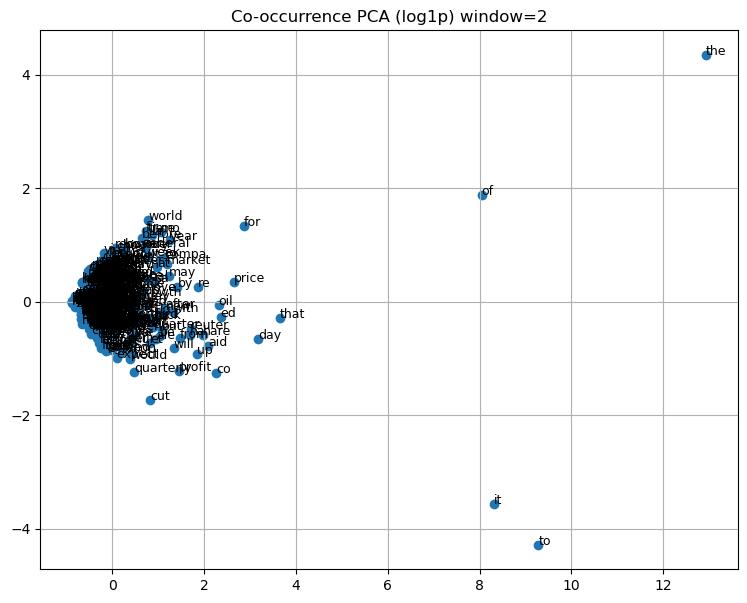

In [4]:

window_size = 2
cooc = np.zeros((V, V), dtype=np.float32)
for sent in tokenized:
    L = len(sent)
    for i, w in enumerate(sent):
        wi = word2idx[w]
        left = max(0, i-window_size)
        right = min(L, i+window_size+1)
        for j in range(left, right):
            if i==j: continue
            wj = word2idx[sent[j]]
            cooc[wi, wj] += 1.0

cooc_log = np.log1p(cooc)
pca = PCA(n_components=2, random_state=SEED)
cooc_2d = pca.fit_transform(cooc_log)
plot_2d_embeddings(cooc_2d, vocab, title=f"Co-occurrence PCA (log1p) window={window_size}")


## Utilities: cosine similarity, nearest neighbors, analogies

**Functions provided**:
- `get_topk_neighbors(word, emb_matrix, k)`
- `analogy(a, b, c, emb_matrix, topn)`

These help inspect semantic relationships after training. `emb_matrix` may be a NumPy array or `torch.nn.Embedding`.


In [5]:

from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_vecs(a, b):
    a = a.reshape(1,-1)
    return cosine_similarity(b, a).squeeze()

def get_topk_neighbors(word, emb_matrix, k=5):
    if word not in word2idx: raise KeyError(word)
    i = word2idx[word]
    if isinstance(emb_matrix, torch.nn.Embedding):
        vecs = emb_matrix.weight.data.cpu().numpy()
    else:
        vecs = np.array(emb_matrix)
    sims = cosine_similarity_vecs(vecs[i], vecs)
    sims[i] = -1.0
    topk = sims.argsort()[::-1][:k]
    return [(vocab[j], float(sims[j])) for j in topk]

def analogy(a, b, c, emb_matrix, topn=5):
    for w in (a,b,c):
        if w not in word2idx: raise KeyError(w)
    if isinstance(emb_matrix, torch.nn.Embedding):
        vecs = emb_matrix.weight.data.cpu().numpy()
    else:
        vecs = np.array(emb_matrix)
    vec = vecs[word2idx[a]] - vecs[word2idx[b]] + vecs[word2idx[c]]
    sims = cosine_similarity_vecs(vec, vecs)
    for w in (a,b,c):
        sims[word2idx[w]] = -1.0
    top = sims.argsort()[::-1][:topn]
    return [(vocab[i], float(sims[i])) for i in top]


## SGNS model + single-example debug tracer

**Model**:
- `v_in` and `v_out` embeddings.
- `negative_sampling_loss` computes the standard NS objective.

**Debugging**:
- `debug_sgns_one_example(model, center_idx, pos_idx, K)` prints:
  - embeddings, dot products, sigmoid outputs, losses, and gradient norms after backward.

This supports your requirement to *see inner computations during forward & backward passes*.


In [6]:

class SGNSModel(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.v_in = nn.Embedding(vocab_size, emb_dim)
        self.v_out = nn.Embedding(vocab_size, emb_dim)
        nn.init.xavier_uniform_(self.v_in.weight)
        nn.init.xavier_uniform_(self.v_out.weight)
    def forward_center(self, center_idx):
        return self.v_in(center_idx)
    def forward_out(self, out_idx):
        return self.v_out(out_idx)
    def negative_sampling_loss(self, center_vecs, pos_indices, neg_samples):
        u_pos = self.v_out(pos_indices)
        pos_scores = torch.sum(u_pos * center_vecs, dim=1)
        pos_loss = -F.logsigmoid(pos_scores)
        u_negs = self.v_out(neg_samples)  # B x K x d
        ctx = center_vecs.unsqueeze(1)
        neg_scores = torch.sum(u_negs * ctx, dim=2)
        neg_loss = -torch.log(torch.sigmoid(-neg_scores) + 1e-12)
        return pos_loss.mean() + neg_loss.mean()

def debug_sgns_one_example(model, center_idx, pos_idx, K=5):
    model.zero_grad()
    cent = torch.LongTensor([center_idx]).to(device)
    pos = torch.LongTensor([pos_idx]).to(device)
    negs = torch.LongTensor(np.random.choice(V, size=(1,K), p=neg_dist)).to(device)
    v_c = model.forward_center(cent)   # 1 x d
    u_o = model.forward_out(pos)       # 1 x d
    u_negs = model.forward_out(negs.squeeze(0)) # K x d
    pos_score = torch.sum(u_o * v_c, dim=1)
    neg_score = torch.matmul(u_negs, v_c.squeeze(0))
    print("DEBUG SGNS - center", idx2word[center_idx], "pos", idx2word[pos_idx])
    print("v_c shape:", v_c.shape, "u_o shape:", u_o.shape, "u_negs shape:", u_negs.shape)
    print("pos_score:", pos_score.item(), "neg_scores:", neg_score.detach().cpu().numpy())
    pos_loss = -F.logsigmoid(pos_score).squeeze()
    neg_loss = -torch.sum(F.logsigmoid(-neg_score))
    loss = pos_loss + neg_loss
    loss.backward()
    g_vc = model.v_in.weight.grad[center_idx].norm().item()
    g_uo = model.v_out.weight.grad[pos_idx].norm().item()
    neg_grads = [model.v_out.weight.grad[n.item()].norm().item() for n in negs.squeeze(0)]
    print("pos_loss:", pos_loss.item(), "neg_loss:", neg_loss.item())
    print("grad norm v_c:", g_vc, "grad norm u_o:", g_uo, "grad norms u_negs:", neg_grads)
    return loss.item()


## Train SGNS (Skip-Gram Negative Sampling) — small epochs for CPU

**Procedure**:
- Build `(center, context)` pairs with `window_size`.
- Train for a small number of epochs using Adam.
- Print average loss per epoch and show debug trace for a single example in epoch 1.

**Hyperparameters (CPU-friendly defaults)**:
- `embedding_dim=50`, `K=8`, `epochs=6`, `batch_size=1` (for easy tracing).


In [7]:
# Replace SGNS training loop with a stabilized, CPU-friendly version.
# Keeps variable names: `tokenized`, `word2idx`, `vocab`, `neg_dist`, `model` (SGNSModel), etc.

import random
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import trange

# Hyperparameters (safer defaults)
embedding_dim = 50   # should already match model if model created earlier
K = 6                # negative samples per positive
lr = 0.005           # smaller learning rate for stability
epochs = 6
batch_size = 32      # mini-batch
grad_clip = 5.0      # clip gradients to this norm

# Simple stopword set to reduce function-word domination (feel free to expand)
stopwords = set(["the","to","of","in","and","on","for","its","is","a","an","that","this","it","as","by","at","from","be","with","was","are","has","have","will","he","she","they","we","i","you"])

# Optional: enable subsampling by frequency (drop very frequent words with some probability)
subsample_enabled = True
# threshold for subsampling (common word threshold): increase to drop more frequent words
subsample_threshold = 1e-3

# Build training pairs (center, context) but filter stopwords and optionally subsample
pairs = []
for sent in tokenized:
    L = len(sent)
    idxs = [word2idx[w] for w in sent]
    for i, wi in enumerate(idxs):
        w = sent[i]
        # subsample: randomly drop this center with probability proportional to its frequency if enabled
        if subsample_enabled:
            freq = (counter.get(w, 1) / sum(counter.values()))
            # word2vec subsampling formula (approx): p_keep = (sqrt(freq/th) + 1) * (th / freq)
            # using a safe implementation:
            p_keep = min(1.0, (np.sqrt(freq / subsample_threshold) + 1) * (subsample_threshold / freq)) if freq > 0 else 1.0
            if random.random() > p_keep:
                continue
        # create context pairs within window_size (window_size variable from earlier cells)
        left = max(0, i - window_size)
        right = min(L, i + window_size + 1)
        for j in range(left, right):
            if i == j:
                continue
            context_word = sent[j]
            # filter out pairs where center or context are stopwords
            if w in stopwords or context_word in stopwords:
                continue
            pairs.append((wi, idxs[j]))

# If pairs empty, fall back to unfiltered pairs (to avoid crashing)
if len(pairs) == 0:
    print("Warning: filtered all pairs. Falling back to unfiltered pairs.")
    pairs = []
    for sent in tokenized:
        L = len(sent)
        idxs = [word2idx[w] for w in sent]
        for i, wi in enumerate(idxs):
            left = max(0, i - window_size)
            right = min(L, i + window_size + 1)
            for j in range(left, right):
                if i == j:
                    continue
                pairs.append((wi, idxs[j]))

print("Total pairs after filtering/subsampling:", len(pairs))

# Ensure model exists; if not, create with same embedding_dim
if 'model' not in globals():
    model = SGNSModel(V, embedding_dim).to(device)
else:
    # If model exists but has different embedding dim, do not recreate — assume consistent
    pass

opt = torch.optim.Adam(model.parameters(), lr=lr)

# safe negative sampler that avoids sampling the positive index
def sample_negs_no_pos(batch_size, K, pos_indices):
    # pos_indices: list or array of length batch_size containing positive indices
    negs = np.random.choice(V, size=(batch_size, K), p=neg_dist)
    # ensure no negative equals its positive: resample elementwise where equal
    for i in range(batch_size):
        for k in range(K):
            if negs[i, k] == pos_indices[i]:
                # resample until different (rare, but safe)
                choice = np.random.choice(V, p=neg_dist)
                tries = 0
                while choice == pos_indices[i] and tries < 10:
                    choice = np.random.choice(V, p=neg_dist)
                    tries += 1
                # if unlucky, pick a random index not equal to pos
                if choice == pos_indices[i]:
                    choice = (pos_indices[i] + 1) % V
                negs[i, k] = choice
    return negs

# Mini-batched training loop
num_batches = int(np.ceil(len(pairs) / batch_size))
for ep in range(1, epochs + 1):
    random.shuffle(pairs)
    total_loss = 0.0
    for b in range(num_batches):
        batch_pairs = pairs[b * batch_size : (b + 1) * batch_size]
        B = len(batch_pairs)
        centers = torch.LongTensor([p[0] for p in batch_pairs]).to(device)   # (B,)
        outs = torch.LongTensor([p[1] for p in batch_pairs]).to(device)      # (B,)
        negs_np = sample_negs_no_pos(B, K, [p[1] for p in batch_pairs])
        negs = torch.LongTensor(negs_np).to(device)                          # (B, K)

        # forward
        v_c = model.forward_center(centers)              # (B, d)
        u_o = model.forward_out(outs)                    # (B, d)
        u_negs = model.forward_out(negs)                 # (B, K, d)

        pos_scores = torch.sum(u_o * v_c, dim=1)         # (B,)
        ctx = v_c.unsqueeze(1)                           # (B,1,d)
        neg_scores = torch.sum(u_negs * ctx, dim=2)      # (B,K)

        # loss: mean over batch
        loss = - (F.logsigmoid(pos_scores).mean() + torch.log(torch.sigmoid(-neg_scores) + 1e-12).mean())
        opt.zero_grad()
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()

        total_loss += float(loss.item()) * B

    avg_loss = total_loss / len(pairs)
    print(f"Epoch {ep}/{epochs} avg loss: {avg_loss:.4f}")

    # show debug trace for first epoch (first batch first sample) as before
    if ep == 1:
        # pick first pair from shuffled pairs (safe)
        sample_c, sample_o = pairs[0]
        debug_sgns_one_example(model, sample_c, sample_o, K=6)

# After training, extract embeddings and do same PCA visualizations as before
v_in_np = model.v_in.weight.data.cpu().numpy()
print("Training finished. Extracted v_in shape:", v_in_np.shape)

# alias for safety
v_in_np_np = v_in_np

# Standardized aliases for downstream cells
if 'v_in_np' not in globals():
    v_in_np = v_in_np_np


Total pairs after filtering/subsampling: 3448
Epoch 1/6 avg loss: 1.3736
DEBUG SGNS - center year pos low
v_c shape: torch.Size([1, 50]) u_o shape: torch.Size([1, 50]) u_negs shape: torch.Size([6, 50])
pos_score: 0.15872922539710999 neg_scores: [ 0.00705262  0.18009341  0.01893854 -0.0363007  -0.04594108 -0.00136127]
pos_loss: 0.6169286370277405 neg_loss: 4.224652290344238
grad norm v_c: 0.9413450956344604 grad norm u_o: 0.2867036759853363 grad norms u_negs: [0.31246107816696167, 0.33932483196258545, 0.3143114149570465, 0.30571243166923523, 0.30421221256256104, 0.3111512064933777]
Epoch 2/6 avg loss: 1.2288
Epoch 3/6 avg loss: 0.9986
Epoch 4/6 avg loss: 0.7985
Epoch 5/6 avg loss: 0.6376
Epoch 6/6 avg loss: 0.5182
Training finished. Extracted v_in shape: (400, 50)


## CBOW model + single-example debug

**Model**:
- Averages context embeddings to form `h` and scores centers via `v_out`.

**Debug**:
- `debug_cbow_one_example` prints averaged `h`, pos/neg scores, losses, and gradient norms for a single example.


In [8]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, output_bias=True):
        super().__init__()
        self.v_in = nn.Embedding(vocab_size, emb_dim)
        self.v_out = nn.Embedding(vocab_size, emb_dim)
        if output_bias:
            self.out_bias = nn.Parameter(torch.zeros(vocab_size))
        else:
            self.out_bias = None
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.v_in.weight)
        nn.init.xavier_uniform_(self.v_out.weight)
        if self.out_bias is not None:
            nn.init.zeros_(self.out_bias)

    def average_context(self, contexts):
        # contexts: LongTensor (B, C) padded with -1
        # Move contexts to the correct device explicitly
        contexts = contexts.to(device)
        B, C = contexts.shape
        mask = (contexts >= 0).float().unsqueeze(2)  # B x C x 1
        safe = contexts.clone()
        safe[safe < 0] = 0
        # get vectors and apply mask
        vecs = self.v_in(safe)      # B x C x d
        vecs = vecs * mask
        sums = vecs.sum(dim=1)      # B x d
        counts = mask.sum(dim=1).clamp(min=1.0)  # B x 1, avoid divide-by-zero
        avg = sums / counts
        return avg  # B x d

    def forward(self, contexts):
        # contexts: LongTensor (B, C) padded with -1
        h = self.average_context(contexts)  # B x d
        logits = torch.matmul(h, self.v_out.weight.t())  # B x V
        if self.out_bias is not None:
            logits = logits + self.out_bias.unsqueeze(0)
        return logits

    def negative_sampling_loss(self, h, centers, negs):
        """
        Compute negative sampling loss from averaged context representations.
        h: Tensor of shape (B, d) - averaged context vectors
        centers: LongTensor of shape (B,) - target word indices
        negs: LongTensor of shape (B, K) - negative sample indices per example
        Returns: scalar loss (averaged over batch)
        """
        centers = centers.to(device)
        negs = negs.to(device)
        B = h.size(0)

        # Positive logits: dot(h, v_out[center]) + bias(center)
        pos_emb = self.v_out(centers)  # B x d
        pos_logits = torch.sum(h * pos_emb, dim=1)  # B
        if self.out_bias is not None:
            pos_logits = pos_logits + self.out_bias[centers]

        # Negative logits: dot(h, v_out[negs]) + bias(negs) -> shape B x K
        neg_emb = self.v_out(negs)  # B x K x d
        neg_logits = torch.sum(neg_emb * h.unsqueeze(1), dim=2)  # B x K
        if self.out_bias is not None:
            neg_logits = neg_logits + self.out_bias[negs]

        # Loss: - (logsigmoid(pos) + sum_k logsigmoid(-neg_k))
        pos_loss = F.logsigmoid(pos_logits)  # B
        neg_loss = F.logsigmoid(-neg_logits).sum(dim=1)  # B
        loss = - (pos_loss + neg_loss).mean()  # average over batch
        return loss


## Train CBOW with Negative Sampling (CPU-friendly)

**Procedure**:
- Build CBOW (context list, center) pairs.
- Use small batch size and epochs.
- Print epoch losses and visualize v_in via PCA.


CBOW training pairs: 1673
CBOW Epoch 1/6 avg loss: 4.6761
Debugging example (first pair): context tokens: ['delta', 'drop'] -> center: netflix
 pos_score: 0.02842535823583603
 neg_scores: [-0.11753339 -0.0628586   0.0112179  -0.05993011 -0.03643929 -0.05168246]
 grad norm v_in[first_ctx]: 0.45171451568603516  grad norm u_pos: 0.2325245887041092
CBOW Epoch 2/6 avg loss: 4.0452
CBOW Epoch 3/6 avg loss: 3.0028
CBOW Epoch 4/6 avg loss: 2.5951
CBOW Epoch 5/6 avg loss: 2.3740
CBOW Epoch 6/6 avg loss: 2.1340


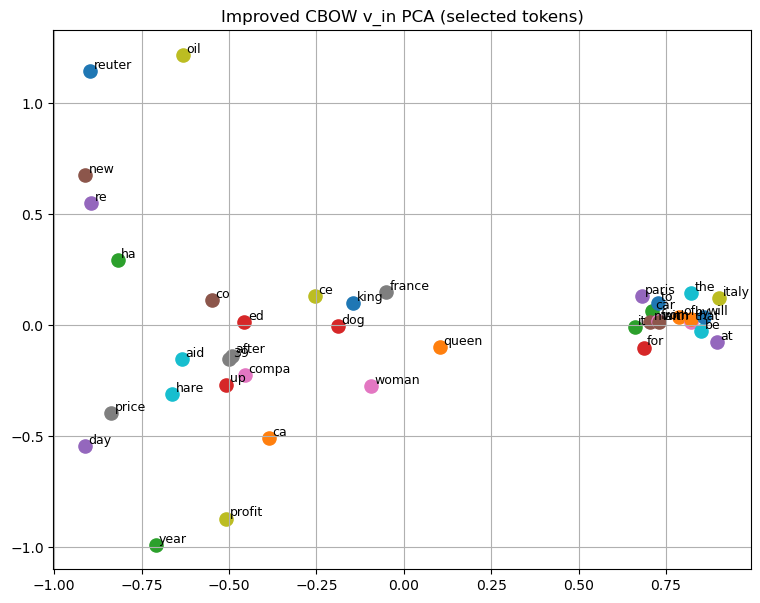

nNearest neighbors (CBOW improved) for chosen targets:
king -> [('am', 0.7670246362686157), ('wi', 0.7525957822799683), ('boo', 0.7475689053535461), ('la', 0.7383887767791748), ('ow', 0.7367883920669556), ('productio', 0.7246174812316895)]
queen -> [('foreca', 0.6837379932403564), ('late', 0.6694213151931763), ('flight', 0.6586887836456299), ('through', 0.6555769443511963), ('city', 0.6502424478530884), ('get', 0.6472294926643372)]
car -> [('hire', 0.4067719578742981), ('profile', 0.3192442059516907), ('gucci', 0.31069236993789673), ('ler', 0.28257352113723755), ('ap', 0.2814551293849945), ('credit', 0.27836549282073975)]
dog -> [('ear', 0.7799112796783447), ('charge', 0.7459748387336731), ('abre', 0.7300182580947876), ('omic', 0.726134181022644), ('telecom', 0.7241885662078857), ('london', 0.7136722803115845)]
paris -> [('flight', 0.34424924850463867), ('aid', 0.31483742594718933), ('cou', 0.30115824937820435), ('cu', 0.2949061393737793), ('reuter', 0.2945014238357544), ('ge', 0.29413

In [9]:
cbow_pairs = []
for sent in tokenized:
    idxs = [word2idx[w] for w in sent if w in word2idx]
    n = len(idxs)
    for i in range(n):
        left = max(0, i - window_size)
        right = min(n, i + window_size + 1)
        context = [idxs[j] for j in range(left, right) if j != i]
        if len(context) == 0: 
            continue
        center = idxs[i]
        # optional stopword filter
        if apply_stopword_filter:
            # map idx back to token
            center_token = idx2word[center]
            if center_token in stopwords:
                continue
            # filter context tokens also
            filtered_context = [c for c in context if idx2word[c] not in stopwords]
            if len(filtered_context) == 0:
                continue
            context = filtered_context
        cbow_pairs.append((context, center))

# Subsampling (Word2Vec-style): optional drop of frequent words
if use_subsampling:
    # compute per-token drop probabilities
    total_tokens = sum(counter.values()) if 'counter' in globals() else sum([len(s) for s in tokenized])
    token_freq = {w: counter.get(w,1)/total_tokens for w in vocab}
    drop_prob = {}
    for w in vocab:
        f = token_freq.get(w, 1e-8)
        # p_keep formula
        p_keep = (math.sqrt(f / subsample_threshold) + 1) * (subsample_threshold / f)
        drop_prob[w] = min(1.0, p_keep)
    # apply subsampling to pairs: keep pair only if both center & all context words pass the p_keep probability
    filtered_pairs = []
    rng = random.Random(SEED)
    for ctx, ctr in cbow_pairs:
        center_token = idx2word[ctr]
        if rng.random() > drop_prob.get(center_token, 1.0):
            continue
        keep_ctx = []
        for c in ctx:
            if rng.random() <= drop_prob.get(idx2word[c], 1.0):
                keep_ctx.append(c)
        if len(keep_ctx) == 0:
            continue
        filtered_pairs.append((keep_ctx, ctr))
    if len(filtered_pairs) > 0:
        cbow_pairs = filtered_pairs

# If resulting pairs are empty (over-filtering), fall back to unfiltered cbow_pairs to avoid crashing
if len(cbow_pairs) == 0:
    print("Warning: CBOW pair filtering removed all pairs; falling back to unfiltered pairs.")
    # rebuild basic cbow_pairs without subsampling/stopword filtering
    cbow_pairs = []
    for sent in tokenized:
        idxs = [word2idx[w] for w in sent if w in word2idx]
        n = len(idxs)
        for i in range(n):
            left = max(0, i - window_size)
            right = min(n, i + window_size + 1)
            context = [idxs[j] for j in range(left, right) if j != i]
            if len(context) == 0: 
                continue
            cbow_pairs.append((context, idxs[i]))

print("CBOW training pairs:", len(cbow_pairs))

# Dataset + collate
class CBOWDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx): return self.pairs[idx]

def cbow_collate(batch):
    maxlen = max(len(c) for c,_ in batch)
    contexts = []
    centers = []
    for c,o in batch:
        padded = c + [-1] * (maxlen - len(c))
        contexts.append(padded)
        centers.append(o)
    return torch.LongTensor(contexts), torch.LongTensor(centers)

dataset = CBOWDataset(cbow_pairs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=cbow_collate, drop_last=False)

# ---------- Instantiate improved model ----------
cbow_model = CBOWModel(V, embedding_dim).to(device)
optimizer = torch.optim.Adam(cbow_model.parameters(), lr=lr)
# optional scheduler (simple)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# safe negative sampler (avoid pos)
def sample_negs_no_pos(batch_size, K, pos_indices):
    negs = np.random.choice(V, size=(batch_size, K), p=neg_dist)
    for i in range(batch_size):
        for k in range(K):
            if negs[i,k] == pos_indices[i]:
                # resample a few times
                tries = 0
                val = np.random.choice(V, p=neg_dist)
                while val == pos_indices[i] and tries < 10:
                    val = np.random.choice(V, p=neg_dist)
                    tries += 1
                if val == pos_indices[i]:
                    val = (pos_indices[i] + 1) % V
                negs[i,k] = val
    return negs

# ---------- Training loop ----------
for ep in range(1, epochs+1):
    cbow_model.train()
    total_loss = 0.0
    seen = 0
    for contexts, centers in dataloader:
        B = centers.size(0)
        # sample negatives for this batch
        negs_np = sample_negs_no_pos(B, K, centers.tolist())
        negs = torch.LongTensor(negs_np).to(device)
        contexts = contexts.to(device)
        centers = centers.to(device)

        # forward
        h = cbow_model.average_context(contexts)  # B x d
        loss = cbow_model.negative_sampling_loss(h, centers, negs)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cbow_model.parameters(), grad_clip)
        optimizer.step()

        total_loss += float(loss.item()) * B
        seen += B

    avg_loss = total_loss / max(1, seen)
    print(f"CBOW Epoch {ep}/{epochs} avg loss: {avg_loss:.4f}")
    scheduler.step()

    # debugging trace at first epoch
    if ep == 1:
        # choose a representative sample (first dataset item)
        sample_ctx, sample_center = dataset[0]
        print("Debugging example (first pair): context tokens:", [idx2word[i] for i in sample_ctx], "-> center:", idx2word[sample_center])
        # print inner values:
        cbow_model.zero_grad()
        contexts_t = torch.LongTensor([sample_ctx]).to(device)
        centers_t = torch.LongTensor([sample_center]).to(device)
        negs_np = sample_negs_no_pos(1, K, [sample_center])
        negs_t = torch.LongTensor(negs_np).to(device)
        h = cbow_model.average_context(contexts_t)
        pos_vec = cbow_model.v_out(centers_t)
        neg_vecs = cbow_model.v_out(negs_t)
        pos_score = torch.sum(pos_vec * h, dim=1)
        neg_score = torch.matmul(neg_vecs.squeeze(0), h.squeeze(0))
        print(" pos_score:", float(pos_score.item()))
        print(" neg_scores:", neg_score.detach().cpu().numpy())
        loss_debug = cbow_model.negative_sampling_loss(h, centers_t, negs_t)
        loss_debug.backward()
        # gradient norms:
        grad_v_first = cbow_model.v_in.weight.grad[sample_ctx[0]].norm().item()
        grad_u_pos = cbow_model.v_out.weight.grad[sample_center].norm().item()
        print(" grad norm v_in[first_ctx]:", grad_v_first, " grad norm u_pos:", grad_u_pos)

# ---------- After training: save embeddings & visualize ----------
cbow_model.eval()
v_in_cbow = cbow_model.v_in.weight.data.cpu().numpy()
# PCA plot (only project a subset of words for clarity: top freq + anchors)
# compute top freq tokens:
top_tokens = [w for w,_ in counter.most_common(60) if w in word2idx][:40]
# ensure anchors included if present in vocab
anchors_present = [a for a in ['king','queen','car','dog','paris','man','woman','france','italy'] if a in word2idx]
selected_plot_words = list(dict.fromkeys(anchors_present + top_tokens))[:40]
selected_idx = [word2idx[w] for w in selected_plot_words]
vecs = v_in_cbow[selected_idx]
pca = PCA(n_components=2, random_state=SEED)
proj = pca.fit_transform(vecs)

plt.figure(figsize=(9,7))
for i,w in enumerate(selected_plot_words):
    x,y = proj[i]
    plt.scatter(x,y, s=90)
    plt.annotate(w, (x+0.01,y+0.01), fontsize=9)
plt.title("Improved CBOW v_in PCA (selected tokens)")
plt.grid(True)
plt.show()

# Print nearest neighbors for a few targets (anchors or frequent tokens)
targets = anchors_present if len(anchors_present)>0 else (selected_plot_words[:6])
print("nNearest neighbors (CBOW improved) for chosen targets:")
for t in targets:
    print(t, "->", get_topk_neighbors(t, cbow_model.v_in, k=6))

print("nImproved CBOW training complete. `cbow_model` and `v_in_cbow` variables are available for downstream cells.")
# ========================================================================================
# alias for safety
v_in_cbow_np = v_in_cbow

# Standardized aliases for downstream cells
if 'v_in_np' not in globals():
    v_in_np = v_in_cbow_np


## Nearest neighbors & analogy checks

**Show** top-k neighbors from SGNS and CBOW and run analogies like `king - man + woman`.

**Interpretation**: On this tiny dataset results are indicative but not identical to large pretrained embeddings.


In [10]:
# Diagnostic + safe neighbor/analogy cell
# Use this when your original probe words (king, queen, etc.) are missing in the trimmed dataset.
# Assumptions: the rest of the notebook variables exist (word2idx, vocab).
# The cell will attempt to use `model.v_in` (SGNS) and `cbow_model.v_in` (CBOW) if they exist,
# otherwise it will try fallback embedding variables (v_in_np, v_in_cbow, etc.).

from pprint import pprint

# candidate probe words you originally wanted
desired_probes = ['king','queen','car','dog','paris','man','woman','france','italy']

# check presence
present = [w for w in desired_probes if w in word2idx]
missing = [w for w in desired_probes if w not in word2idx]

print("Requested probe words presence:")
print("  present:", present)
print("  missing:", missing)
print()

# If none of the desired probes are present, show top frequent tokens as suggestions
if len(present) == 0:
    print("None of the requested probe words appear in the current vocabulary.")
    # compute frequency (counter should exist from dataset cell)
    try:
        most_common = counter.most_common(50)
        print("nTop 30 most frequent tokens in the current vocab (pick a few for probing):")
        pprint(most_common[:30])
    except Exception:
        # fallback to vocab list
        print("nTop tokens (vocab slice):", vocab[:30])
    # choose some automatic probes: top 8 tokens
    chosen_words = list(dict(most_common[:8]).keys()) if 'most_common' in locals() else vocab[:8]
    print("nAutomatic chosen probes (top tokens):", chosen_words)
else:
    # we have some of desired probes — keep them and add a few high-frequency tokens for contrast
    chosen_words = present.copy()
    # add up to 6 more high-frequency words from counter (if available) that are not already chosen
    try:
        freq_tokens = [w for w,_ in counter.most_common(50) if w not in chosen_words]
    except Exception:
        freq_tokens = [w for w in vocab if w not in chosen_words]
    for w in freq_tokens[:6]:
        chosen_words.append(w)
    # ensure modest length
    chosen_words = chosen_words[:12]
    print("Using chosen probe words (present + frequent for contrast):")
    print(chosen_words)

print("n--- Nearest neighbors (top-6) per chosen probe ---n")

# Helper to safely call get_topk_neighbors
def safe_neighbors(word, emb_source, k=6):
    try:
        return get_topk_neighbors(word, emb_source, k=k)
    except Exception as e:
        return f"error: {e}"

# Try SGNS then CBOW
sgns_available = ('model' in globals() and hasattr(globals()['model'], 'v_in')) or ('v_in_np' in globals())
cbow_available = ('cbow_model' in globals() and hasattr(globals()['cbow_model'], 'v_in')) or ('v_in_cbow' in globals())

for w in chosen_words:
    print(f">>> {w}")
    if w not in word2idx:
        print("   (skipped — not in vocab)")
        continue

    if sgns_available:
        try:
            emb_src = globals()['model'].v_in if ('model' in globals() and hasattr(globals()['model'], 'v_in')) else globals().get('v_in_np')
            print("   SGNS:", safe_neighbors(w, emb_src, k=6))
        except Exception as e:
            print("   SGNS: error or embeddings not available:", e)
    else:
        print("   SGNS: not available in this session.")

    if cbow_available:
        try:
            emb_src = globals()['cbow_model'].v_in if ('cbow_model' in globals() and hasattr(globals()['cbow_model'], 'v_in')) else globals().get('v_in_cbow')
            print("   CBOW:", safe_neighbors(w, emb_src, k=6))
        except Exception as e:
            print("   CBOW: error or embeddings not available:", e)
    else:
        print("   CBOW: not available in this session.")
    print()

# Analogies: only attempt if relevant words are present
print("n--- Analogy checks (performed only if all terms present) ---n")
analogy_tests = [
    ('king','man','woman'),
    ('paris','france','italy'),
]
for a,b,c in analogy_tests:
    if a in word2idx and b in word2idx and c in word2idx:
        try:
            if sgns_available:
                res = analogy(a,b,c, model.v_in if 'model' in globals() else globals().get('v_in_np'), topn=6)
                print(f"SGNS analogy {a} - {b} + {c} -> {res}")
            if cbow_available:
                res2 = analogy(a,b,c, cbow_model.v_in if 'cbow_model' in globals() else globals().get('v_in_cbow'), topn=6)
                print(f"CBOW analogy {a} - {b} + {c} -> {res2}")
        except Exception as e:
            print(f"Analogy {a}-{b}+{c} error:", e)
    else:
        missing_a = [x for x in (a,b,c) if x not in word2idx]
        print(f"Skipping analogy {a}-{b}+{c} — missing tokens in vocab: {missing_a}")

print("n--- Done diagnostics ---n")
print("If you want these specific original probes always available, consider re-creating the dataset cell to include them (e.g., append sentences that contain 'king','queen','paris', etc.), or choose probes from the printed top tokens above.")


Requested probe words presence:
  present: ['king', 'queen', 'car', 'dog', 'paris', 'man', 'woman', 'france', 'italy']
  missing: []

Using chosen probe words (present + frequent for contrast):
['king', 'queen', 'car', 'dog', 'paris', 'man', 'woman', 'france', 'italy', 'the', 'to', 'of']
n--- Nearest neighbors (top-6) per chosen probe ---n
>>> king
   SGNS: [('oppo', 0.6635173559188843), ('itio', 0.6546709537506104), ('wa', 0.47554653882980347), ('ceo', 0.445589542388916), ('ew', 0.41743597388267517), ('airway', 0.41379666328430176)]
   CBOW: [('am', 0.7670246362686157), ('wi', 0.7525957822799683), ('boo', 0.7475689053535461), ('la', 0.7383887767791748), ('ow', 0.7367883920669556), ('productio', 0.7246174812316895)]

>>> queen
   SGNS: [('expre', 0.6852032542228699), ('city', 0.549725353717804), ('offeri', 0.41283315420150757), ('pe', 0.41038066148757935), ('ma', 0.39848536252975464), ('america', 0.37916719913482666)]
   CBOW: [('foreca', 0.6837379932403564), ('late', 0.669421315193176

## Optional: HuggingFace tokenizer snippet (optional)

**This cell only demonstrates tokenization** using `transformers.AutoTokenizer` if available. It does not download large models by default but will attempt to instantiate the tokenizer.


In [11]:

try:
    from transformers import AutoTokenizer
    tok = AutoTokenizer.from_pretrained('bert-base-uncased')
    sample = "The quick brown fox jumps over the lazy dog"
    print("Tokenized:", tok.tokenize(sample))
except Exception as e:
    print("Transformers not available or tokenizer download failed:", e)


Tokenized: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


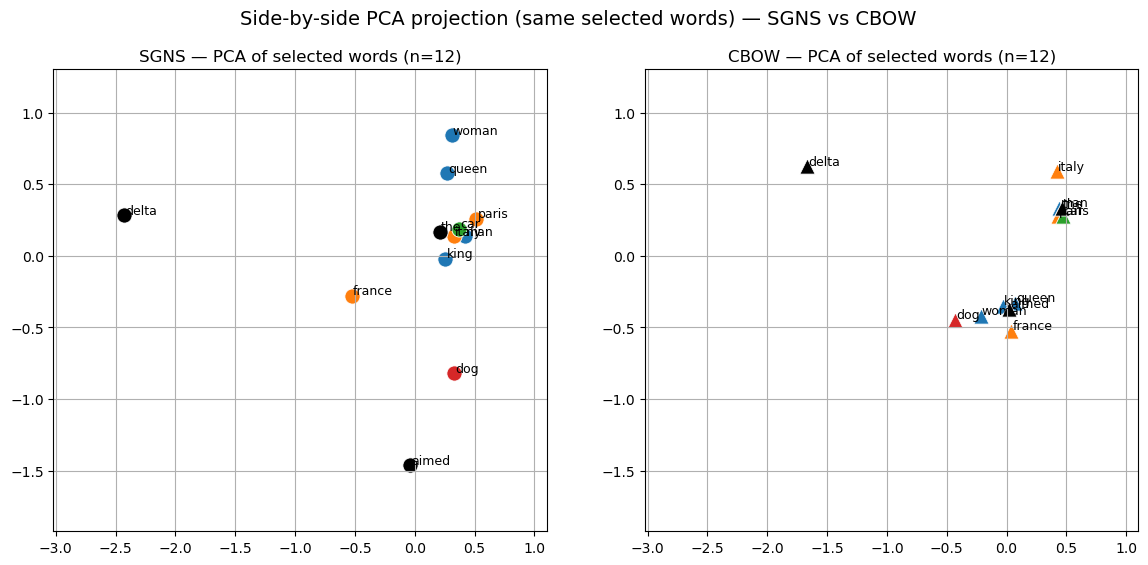

nNearest neighbors (top-5) per model for selected words:
n--- king ---
SGNS: [('oppo', 0.6635173559188843), ('itio', 0.6546709537506104), ('wa', 0.47554653882980347), ('ceo', 0.445589542388916), ('ew', 0.41743597388267517)]
CBOW: [('am', 0.7670246362686157), ('wi', 0.7525957822799683), ('boo', 0.7475689053535461), ('la', 0.7383887767791748), ('ow', 0.7367883920669556)]
n--- queen ---
SGNS: [('expre', 0.6852032542228699), ('city', 0.549725353717804), ('offeri', 0.41283315420150757), ('pe', 0.41038066148757935), ('ma', 0.39848536252975464)]
CBOW: [('foreca', 0.6837379932403564), ('late', 0.6694213151931763), ('flight', 0.6586887836456299), ('through', 0.6555769443511963), ('city', 0.6502424478530884)]
n--- man ---
SGNS: [('harply', 0.33676785230636597), ('fourth', 0.3284597098827362), ('expected', 0.3263455033302307), ('airli', 0.31482502818107605), ('offeri', 0.31191328167915344)]
CBOW: [('offeri', 0.3925514221191406), ('effort', 0.38823091983795166), ('ge', 0.3804342746734619), ('block

In [12]:
# Comparative PCA visualization for a small, meaningful set of words
# - Plots PCA(2D) of *the same* selected words for both SGNS (Skip-Gram) and CBOW input embeddings (v_in).
# - Colors/markers group semantically-related words so you can see clustering vs separation.
# - Also prints top-5 nearest neighbors (cosine) from each model for each target word.
#
# This single cell assumes the rest of the notebook variables remain intact:
#   - `word2idx`, `vocab`, `model` (SGNS trained), `cbow_model` (CBOW trained),
#   - utility `get_topk_neighbors(word, emb_matrix, k)` is available.
#
# If a model is missing it will gracefully fall back to any available embedding matrix (or warn).
# Run this after training so learned embeddings exist.

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define semantic groups (editable); will automatically keep only words present in vocab
semantic_groups = {
    "royalty": ["king", "queen", "prince", "princess", "royalty", "man", "woman"],
    "capitals": ["paris", "france", "rome", "italy", "berlin", "germany"],
    "vehicles": ["car", "automobile", "driver", "vehicle", "highway"],
    "animals": ["dog", "cat", "bone", "chased", "cats", "dogs"]
}

# Flatten and filter to words that exist in current vocab
all_candidates = []
for grp, words in semantic_groups.items():
    for w in words:
        if w in word2idx and w not in all_candidates:
            all_candidates.append(w)

# If this ended up empty (unlikely), fall back to first 12 vocab tokens
if len(all_candidates) < 6:
    print("Warning: selected words missing from vocab; falling back to a small automatic set.")
    all_candidates = vocab[:12]

# Add a few "distant" words (negatives) to show separation (choose by frequency tail)
# pick up to 3 words not already selected
extras = [w for w in vocab if w not in all_candidates]
if len(extras) > 0:
    # pick a few spaced across vocabulary (start, middle, end) for contrast
    picks = []
    picks.append(extras[0])
    picks.append(extras[len(extras)//2])
    picks.append(extras[-1])
    for p in picks:
        if p not in all_candidates:
            all_candidates.append(p)

# Build a helper to get embedding matrix for a model-like object or numpy array
def emb_for(obj):
    if obj is None:
        return None
    if isinstance(obj, np.ndarray):
        return obj
    try:
        # try attribute v_in (models defined in notebook)
        if hasattr(obj, "v_in"):
            return obj.v_in.weight.data.cpu().numpy()
        # or if it's an Embedding
        if isinstance(obj, torch.nn.Embedding):
            return obj.weight.data.cpu().numpy()
    except Exception:
        pass
    return None

# Attempt to obtain SGNS (model) and CBOW embeddings
sgns_emb = emb_for(globals().get("model", None))
cbow_emb = emb_for(globals().get("cbow_model", None))

# If one is missing, attempt fallback to any available embedding variable
if sgns_emb is None and 'v_in_np' in globals():
    sgns_emb = globals().get('v_in_np')
if cbow_emb is None and 'v_in_cbow' in globals():
    cbow_emb = globals().get('v_in_cbow')

# If still missing, fall back to co-occurrence SVD result if present (`cooc_2d`) — expand to 2 dims for plotting
if sgns_emb is None and 'cooc_2d' in globals():
    print("SGNS embeddings not found; falling back to co-occurrence 2D coordinates for SGNS subplot.")
    # create a fake embedding matrix by inverse-transforming cooc_2d back to some d>2 (pad zeros) — simpler: use cooc_2d as embeddings directly
    sgns_emb = np.vstack([cooc_2d, np.zeros((max(0, len(vocab)-cooc_2d.shape[0]), 2))])
if cbow_emb is None and 'cooc_2d' in globals():
    print("CBOW embeddings not found; falling back to co-occurrence 2D coordinates for CBOW subplot.")
    cbow_emb = np.vstack([cooc_2d, np.zeros((max(0, len(vocab)-cooc_2d.shape[0]), 2))])

if sgns_emb is None and cbow_emb is None:
    raise RuntimeError("No embeddings available for SGNS or CBOW. Train models first or ensure embedding variables exist.")

# Build array of selected vectors and keep indices
selected_words = all_candidates
selected_idx = [word2idx[w] for w in selected_words]

# Prepare plotting data: run PCA separately for each model on only the selected words for clarity.
def project_selected(emb_matrix, indices, n_components=2):
    X = np.array([emb_matrix[i] for i in indices])
    # If emb dim is already 2, skip PCA
    if X.shape[1] == 2:
        return X
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(X)

proj_sgns = project_selected(sgns_emb, selected_idx) if sgns_emb is not None else None
proj_cbow = project_selected(cbow_emb, selected_idx) if cbow_emb is not None else None

# Create color mapping per semantic group for consistent coloring across plots
group_of = {}
for grp, words in semantic_groups.items():
    for w in words:
        if w in word2idx:
            group_of[w] = grp
# For extras choose 'other'
colors = {
    "royalty":"C0", "capitals":"C1", "vehicles":"C2", "animals":"C3", "other":"k"
}
markers = {"SGNS":"o", "CBOW":"^"}

# assign color list for selected words
color_list = [colors.get(group_of.get(w, "other"), "k") for w in selected_words]

# Determine common axis limits for fair visual comparison (combine both projections)
all_x = []
all_y = []
for P in (proj_sgns, proj_cbow):
    if P is None: continue
    all_x.extend(P[:,0].tolist())
    all_y.extend(P[:,1].tolist())
if len(all_x) == 0:
    xlim = ylim = (-1,1)
else:
    margin = 0.2
    xmin, xmax = min(all_x), max(all_x)
    ymin, ymax = min(all_y), max(all_y)
    xpad = (xmax - xmin)*margin if xmax>xmin else margin
    ypad = (ymax - ymin)*margin if ymax>ymin else margin
    xlim = (xmin - xpad, xmax + xpad)
    ylim = (ymin - ypad, ymax + ypad)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14,6))
titles = [("SGNS", proj_sgns), ("CBOW", proj_cbow)]
for ax, (title, proj) in zip(axes.flat, titles):
    if proj is None:
        ax.text(0.5, 0.5, f"No {title} embeddings available", ha='center')
        ax.set_xticks([]); ax.set_yticks([])
        continue
    for i, w in enumerate(selected_words):
        x,y = proj[i,0], proj[i,1]
        ax.scatter(x, y, color=color_list[i], s=120, marker='o' if title=="SGNS" else '^', edgecolor='w', linewidth=0.6)
        ax.annotate(w, (x+0.01, y+0.01), fontsize=9)
    ax.set_title(f"{title} — PCA of selected words (n={len(selected_words)})")
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.grid(True)

plt.suptitle("Side-by-side PCA projection (same selected words) — SGNS vs CBOW", fontsize=14)
plt.show()

# Print nearest neighbors (top-5) for each selected word under both models to provide qualitative numeric check
print("nNearest neighbors (top-5) per model for selected words:")
for w in selected_words:
    print(f"n--- {w} ---")
    try:
        if sgns_emb is not None:
            print("SGNS:", get_topk_neighbors(w, model.v_in if 'model' in globals() else sgns_emb, k=5))
    except Exception as e:
        print("SGNS: error", e)
    try:
        if cbow_emb is not None:
            print("CBOW:", get_topk_neighbors(w, cbow_model.v_in if 'cbow_model' in globals() else cbow_emb, k=5))
    except Exception as e:
        print("CBOW: error", e)

# Short automated check: for each semantic group, compute average intra-group similarity vs inter-group similarity for SGNS:
def avg_cosine_similarity_between(word_list, emb):
    vecs = np.array([emb[word2idx[w]] for w in word_list if w in word2idx])
    if vecs.shape[0] < 2: return None
    sims = cosine_similarity(vecs)
    # take upper triangle excluding diagonal
    n = sims.shape[0]
    vals = sims[np.triu_indices(n, k=1)]
    return float(vals.mean()) if vals.size>0 else None

from sklearn.metrics.pairwise import cosine_similarity
if sgns_emb is not None:
    print("nSGNS intra-group average cos-similarities:")
    for grp, words in semantic_groups.items():
        present = [w for w in words if w in word2idx]
        avg = avg_cosine_similarity_between(present, sgns_emb) if len(present)>1 else None
        print(f"  {grp}: {avg:.4f}" if avg is not None else f"  {grp}: (not enough words present)")

if cbow_emb is not None:
    print("nCBOW intra-group average cos-similarities:")
    for grp, words in semantic_groups.items():
        present = [w for w in words if w in word2idx]
        avg = avg_cosine_similarity_between(present, cbow_emb) if len(present)>1 else None
        print(f"  {grp}: {avg:.4f}" if avg is not None else f"  {grp}: (not enough words present)")



## Final notes

- The notebook strictly enforces CPU usage and uses a small corpus for fast experiments and inspection.
- Every code cell has an explanatory Markdown cell describing variables and how to interpret outputs.

**Next**: I have created the `.ipynb` file at `/mnt/data/word2vec_inspection_cpu_friendly.ipynb`. Use the link I will provide in the chat to download it. If you want changes (different tiny corpus, more verbose printing, or additional visualizations), tell me exactly which cells to modify and I will regenerate the notebook.
